2025-07-31 02:54:13 — INFO — Evaluation notebook start.
2025-07-31 02:54:13 — INFO — Installing python-dotenv (missing)
2025-07-31 02:54:14 — INFO — Installing Pillow (missing)
2025-07-31 02:54:15 — INFO — Installing google-genai (missing)
2025-07-31 02:54:16 — WARNING — Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
2025-07-31 02:54:16 — INFO — GenAI client initialized.
2025-07-31 02:54:16 — INFO — Hyper-Kvasir dataset found at D:\Projects\gemini_image_segmentation\segmented-images
2025-07-31 02:54:16 — INFO — Loaded 1000 total images. Will evaluate a random sample of 150.
2025-07-31 02:54:16 — INFO — Rate limiting is ENABLED. A delay of 9s will be added between requests.
2025-07-31 02:54:16 — INFO — Request timeout is ENABLED. API calls will fail after 300s.


Evaluating 150-Image Sample:   0%|          | 0/150 [00:00<?, ?it/s]

2025-07-31 02:54:16 — INFO — Processing: c875a002-a25d-4941-a3f0-f47c8c6696dc.jpg
2025-07-31 02:54:16 — INFO — AFC is enabled with max remote calls: 10.
2025-07-31 02:54:20 — INFO — HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-07-31 02:54:20 — INFO — AFC remote call 1 is done.
2025-07-31 02:54:29 — INFO — Processing: 832c8d87-0a93-4c60-82b8-9192be2f1663.jpg
2025-07-31 02:54:29 — INFO — AFC is enabled with max remote calls: 10.
2025-07-31 02:54:33 — INFO — HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-07-31 02:54:33 — INFO — AFC remote call 1 is done.
2025-07-31 02:54:42 — INFO — Processing: e636561e-4119-48be-b0ba-1daa1870d39e.jpg
2025-07-31 02:54:42 — INFO — AFC is enabled with max remote calls: 10.
2025-07-31 02:54:44 — INFO — HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flas

---------------------------------------------
           GenAI Segmentation Model Evaluation Report
---------------------------------------------
Total Images Evaluated: 150

--- Performance Metrics (on successful detections) ---
Mean IoU:              0.7545 (95% CI: 0.7232 - 0.7874)
Mean Dice Coefficient: 0.8415 (95% CI: 0.8138 - 0.8677)

--- Operational & Failure Metrics ---
Mean API Latency:      6.68s (95% CI: 2.91s - 12.48s)
JSON Parse Success:    97.3% (146/150)
False Negatives:       2 images (1.3%)
Low IoU Failures:      11 images (7.3%)
---------------------------------------------


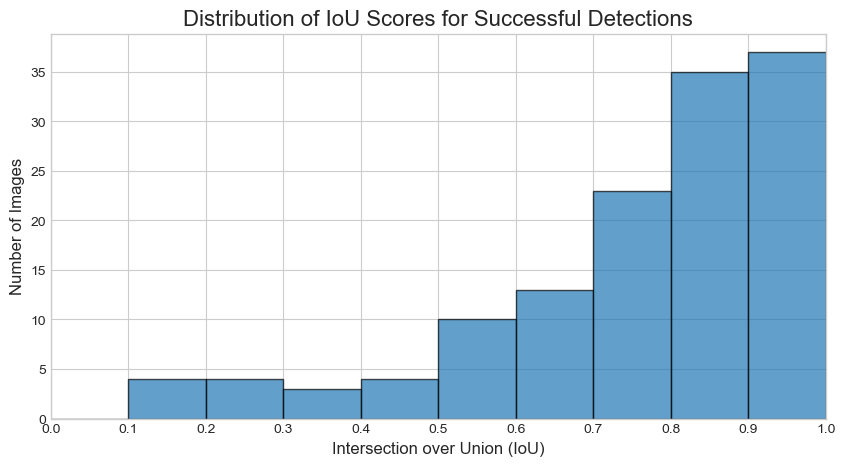

"\n✅ Evaluation complete. The report above summarizes the model's performance on the pilot dataset.\n"

In [5]:
# %% [markdown]
"""
# 02 Model Evaluation · **GenAI SDK edition**

*Last sync 31 Jul 2025*

This notebook evaluates the performance of the `gemini_seg` function on a predefined pilot set of images. It systematically calculates and aggregates key performance and operational metrics by comparing the model's output against ground-truth data.

**Key Features:**
- **Self-Contained:** Automatically generates the master list of images if it doesn't exist.
- **Modular Test Size:** A parameter (`NUM_IMAGES_TO_TEST`) allows for easy configuration of the evaluation run size.
- **Randomized Sampling:** Images are randomly sampled from the master list for each run to ensure representative results.
- **Bootstrapped Confidence Intervals:** An optional toggle (`ENABLE_BOOTSTRAPPING`) enables the calculation of 95% confidence intervals for key metrics.
- **Rate Limiting:** An optional toggle (`ENABLE_RATE_LIMITING`) introduces a delay between API calls to prevent `429` resource exhausted errors.
- **Request Timeout:** Implements a robust, client-side timeout to prevent frozen requests from stalling the script.
- **Failure Analysis:** Automatically categorizes and saves lists of failed images for review.
- **Results Persistence:** Saves a detailed summary of the final metrics to a JSON file for every run.
"""

# %%
# ---------- Preamble & Setup ----------
import sys, logging, os, subprocess, importlib.util, json, io, random, base64, dataclasses, time
from datetime import datetime
from pathlib import Path
from typing import Tuple, List
from concurrent.futures import ThreadPoolExecutor, TimeoutError

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageColor, UnidentifiedImageError
from tqdm.notebook import tqdm
from dotenv import load_dotenv, find_dotenv

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s — %(levelname)s — %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logging.info("Evaluation notebook start.")

# %%
# ---------- Ensure helper packages ----------
def _ensure(pkg: str):
    """Checks if a package is installed and installs it if not."""
    if importlib.util.find_spec(pkg) is None:
        logging.info("Installing %s (missing)", pkg)
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "--quiet"])

for extra in ("python-dotenv", "tqdm", "matplotlib", "numpy", "Pillow", "google-genai"):
    _ensure(extra)

# %%
# ---------- GenAI Client & Dataset Paths ----------
load_dotenv(find_dotenv(), override=False)

from google import genai
from google.genai.types import GenerateContentConfig, Part, ThinkingConfig

if not os.getenv("GOOGLE_API_KEY"):
    raise ValueError("GOOGLE_API_KEY not found. Ensure it is in your .env file.")

client = genai.Client()
logging.info("GenAI client initialized.")


hk_dir = Path(os.getenv("HK_SEG_DIR", "segmented-images")).expanduser().resolve()
if not hk_dir.is_dir():
    raise FileNotFoundError(f"Dataset directory not found at {hk_dir}.")
logging.info("Hyper-Kvasir dataset found at %s", hk_dir)

# %% [markdown]
"""
### Core Functions from Previous Notebook

To keep this notebook self-contained, we are including the necessary functions from the previous script (`01_environment_prep`). This includes the `SegmentationMask` dataclass, the JSON parsing utilities, and the core `gemini_seg` API call function.

**Modification for Evaluation:**
- The `gemini_seg` function has been slightly modified to return a third value: `parse_success` (a boolean), allowing us to explicitly track JSON parsing reliability.
"""

# %%
# ---------- Core Segmentation Logic (Copied & Adapted) ----------

@dataclasses.dataclass(frozen=True)
class SegmentationMask:
    """A dataclass to hold a single segmentation mask's data."""
    y0: int
    x0: int
    y1: int
    x1: int
    mask: np.ndarray # Full-size mask [img_height, img_width] with values 0..255
    label: str

def parse_json(json_output: str) -> str:
    """Cleans the model's JSON output by removing markdown fencing."""
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line.strip() == "```json":
            json_content = "\n".join(lines[i+1:])
            closing_fence_index = json_content.find("```")
            if closing_fence_index != -1:
                json_content = json_content[:closing_fence_index]
            return json_content.strip()
    return json_output.strip()

def parse_segmentation_masks(
    predicted_str: str, *, img_height: int, img_width: int
) -> Tuple[List[SegmentationMask], bool]:
    """
    Parses the model's JSON output into a list of SegmentationMask objects.
    Returns the list of masks and a boolean indicating if JSON parsing was successful.
    """
    cleaned_json = parse_json(predicted_str)
    if not cleaned_json:
        logging.warning("Parsing model output resulted in an empty string.")
        return [], True # Technically not a JSON error, but an empty response.

    try:
        items = json.loads(cleaned_json)
        parse_success = True
    except json.JSONDecodeError as e:
        logging.error(f"Failed to decode JSON: {e}")
        logging.error(f"Problematic string after cleaning: {cleaned_json}")
        return [], False

    masks = []
    for item in items:
        try:
            abs_y0 = int(item["box_2d"][0] / 1000 * img_height)
            abs_x0 = int(item["box_2d"][1] / 1000 * img_width)
            abs_y1 = int(item["box_2d"][2] / 1000 * img_height)
            abs_x1 = int(item["box_2d"][3] / 1000 * img_width)

            if abs_y0 >= abs_y1 or abs_x0 >= abs_x1:
                continue

            label = item["label"]
            png_b64_str = item["mask"]
            png_bytes = base64.b64decode(png_b64_str.removeprefix("data:image/png;base64,"))
            partial_mask_img = Image.open(io.BytesIO(png_bytes))

            bbox_height = abs_y1 - abs_y0
            bbox_width = abs_x1 - abs_x0
            resized_mask = partial_mask_img.resize((bbox_width, bbox_height), resample=Image.Resampling.BILINEAR)
            full_mask_np = np.zeros((img_height, img_width), dtype=np.uint8)
            full_mask_np[abs_y0:abs_y1, abs_x0:abs_x1] = np.array(resized_mask)

            masks.append(SegmentationMask(abs_y0, abs_x0, abs_y1, abs_x1, full_mask_np, label))
        except (KeyError, IndexError, TypeError, base64.binascii.Error, UnidentifiedImageError) as e:
            logging.warning(f"Skipping malformed item in JSON response: {item}. Error: {e}")
            continue
    return masks, parse_success

MODEL_NAME = "gemini-2.5-flash"
PROMPT = (
    'Give the segmentation masks for colorectal polyp. '
    'Output a JSON list of segmentation masks where each entry contains the 2D bounding box in the key "box_2d", '
    'the segmentation mask in key "mask", and the text label in the key "label". '
    'Use descriptive labels.'
)

def gemini_seg(image_obj: Image.Image) -> Tuple[List[SegmentationMask], float, bool]:
    """
    Sends a PIL Image object to Gemini and returns segmentation masks, with a client-side timeout.

    Returns:
        A tuple containing:
        - A list of SegmentationMask objects.
        - The latency of the API call in seconds.
        - A boolean indicating if the JSON response was successfully parsed.
    """
    original_width, original_height = image_obj.size
    
    # Prepare image for API
    img_for_api = image_obj.copy()
    max_dim = 1024
    if img_for_api.height > max_dim or img_for_api.width > max_dim:
        img_for_api.thumbnail((max_dim, max_dim))

    with io.BytesIO() as img_byte_arr:
        img_for_api.save(img_byte_arr, format='JPEG')
        img_bytes = img_byte_arr.getvalue()

    # Configure generation settings
    gen_config = GenerateContentConfig(
        thinking_config=ThinkingConfig(thinking_budget=0),
        temperature=0.5
    )
    image_part = Part.from_bytes(data=img_bytes, mime_type='image/jpeg')
    text_part = Part(text=PROMPT)
    
    # Define the API call as a function to be submitted to the executor
    def do_api_call():
        # The client object is global
        return client.models.generate_content(
            model=MODEL_NAME,
            contents=[image_part, text_part],
            config=gen_config,
        )

    start_time = datetime.now()
    try:
        if ENABLE_REQUEST_TIMEOUT:
            with ThreadPoolExecutor(max_workers=1) as executor:
                future = executor.submit(do_api_call)
                response = future.result(timeout=REQUEST_TIMEOUT_SEC)
        else:
            # Run without timeout if disabled
            response = do_api_call()
        
        latency = (datetime.now() - start_time).total_seconds()
        masks, parse_success = parse_segmentation_masks(
            response.text,
            img_height=original_height,
            img_width=original_width
        )
        return masks, latency, parse_success

    except TimeoutError:
        logging.error(f"API call timed out after {REQUEST_TIMEOUT_SEC} seconds.")
        return [], 0.0, False
    except Exception as e:
        # This broad exception will catch RateLimitError, etc.
        logging.error(f"An error occurred during the gemini_seg function.", exc_info=True)
        return [], 0.0, False

# %% [markdown]
"""
### Metric Calculation Utilities

These functions implement the standard formulas for Intersection over Union (IoU), the Dice Coefficient, and a new function for bootstrapping confidence intervals.
"""

# %%
# ---------- Metric Calculation Functions ----------

def calculate_iou(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Calculates Intersection over Union (IoU) for boolean masks."""
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    if np.sum(union) == 0:
        return 1.0 # If both masks are empty, it's a perfect match.
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_dice(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Calculates the Dice Coefficient for boolean masks."""
    intersection = np.logical_and(y_true, y_pred)
    denominator = np.sum(y_true) + np.sum(y_pred)
    if denominator == 0:
        return 1.0 # If both masks are empty, it's a perfect match.
    dice_score = (2. * np.sum(intersection)) / denominator
    return dice_score

def calculate_bootstrap_ci(data: List[float], n_resamples: int = 1000) -> Tuple[float, float]:
    """Calculates the 95% confidence interval for a list of numbers using bootstrapping."""
    if not data or len(data) < 2:
        return 0.0, 0.0
    
    bootstrapped_means = []
    n_samples = len(data)
    
    for _ in range(n_resamples):
        # Sample with replacement
        resample = np.random.choice(data, size=n_samples, replace=True)
        bootstrapped_means.append(np.mean(resample))
        
    # Calculate the 95% confidence interval
    lower_bound = np.percentile(bootstrapped_means, 2.5)
    upper_bound = np.percentile(bootstrapped_means, 97.5)
    
    return lower_bound, upper_bound

# %% [markdown]
"""
### Evaluation Execution

This is the main loop of the notebook. It will:
1.  **Check for `master_imagelist_hk.txt`** and generate it if it doesn't exist.
2.  Load the list of all available image paths.
3.  **Randomly sample** a specified number of images (`NUM_IMAGES_TO_TEST`).
4.  Iterate through each sampled image, calling the `gemini_seg` function.
5.  **Optionally pause** between calls to respect API rate limits.
6.  Compare the result to the ground-truth mask and store metrics.
7.  A `tqdm` progress bar will show the progress.
"""

# %%
# ---------- Main Evaluation Loop ----------

# <<< --- PARAMETERS TO CONTROL THE EVALUATION --- >>>
NUM_IMAGES_TO_TEST = 150    # Change this value to run on more or fewer images
ENABLE_BOOTSTRAPPING = True  # Set to False to skip the CI calculation
ENABLE_RATE_LIMITING = True  # Set to False if you have a higher-tier plan
RATE_LIMIT_DELAY_SEC = 9     # Delay in seconds between API calls (9s is safe for 10 RPM)
ENABLE_REQUEST_TIMEOUT = True # Set to False to disable timeouts
REQUEST_TIMEOUT_SEC = 300     # Timeout in seconds (e.g., 300s = 5 minutes)
LOW_IOU_THRESHOLD = 0.1       # Threshold below which a detection is considered a failure

# --- Generate Master Image List if it Doesn't Exist ---
master_list_path = hk_dir / "master_imagelist_hk.txt"
if not master_list_path.exists():
    logging.info(f"Master image list not found. Generating it now at: {master_list_path}")
    
    # Scan for all image-mask pairs
    all_img_paths = sorted((hk_dir / "images").iterdir())
    mask_name_set = {p.name for p in (hk_dir / "masks").iterdir()}
    
    valid_pairs = [
        img_path for img_path in all_img_paths if img_path.name in mask_name_set
    ]
    
    if not valid_pairs:
        raise RuntimeError("No valid image-mask pairs found in the dataset directories.")
        
    # Write the list of valid image paths to the master file
    master_list_path.write_text("\n".join(str(p) for p in valid_pairs))
    logging.info(f"Successfully generated master list with {len(valid_pairs)} images.")


# --- Load and Prepare Evaluation Set ---
with open(master_list_path, 'r') as f:
    all_available_paths = [Path(line.strip()) for line in f.readlines()]

# --- Robustness Check for Test Size ---
num_available = len(all_available_paths)
if NUM_IMAGES_TO_TEST > num_available:
    logging.warning(
        f"Requested {NUM_IMAGES_TO_TEST} images, but only {num_available} are available in '{master_list_path.name}'. "
        f"Running evaluation on all {num_available} available images."
    )
    NUM_IMAGES_TO_TEST = num_available

# Randomly sample the images to test
random.seed(42) # for reproducibility
random.shuffle(all_available_paths)
images_to_evaluate = all_available_paths[:NUM_IMAGES_TO_TEST]

logging.info(f"Loaded {num_available} total images. Will evaluate a random sample of {len(images_to_evaluate)}.")
if ENABLE_RATE_LIMITING:
    logging.info(f"Rate limiting is ENABLED. A delay of {RATE_LIMIT_DELAY_SEC}s will be added between requests.")
if ENABLE_REQUEST_TIMEOUT:
    logging.info(f"Request timeout is ENABLED. API calls will fail after {REQUEST_TIMEOUT_SEC}s.")

# --- Initialize storage for results and failures ---
evaluation_results = []
json_failures = []
false_negatives = []
low_iou_failures = []


for img_path in tqdm(images_to_evaluate, desc=f"Evaluating {len(images_to_evaluate)}-Image Sample"):
    try:
        logging.info(f"Processing: {img_path.name}")
        original_image = Image.open(img_path)

        # Execute segmentation
        predicted_masks, latency, parse_success = gemini_seg(original_image)

        # The gemini_seg function now catches the exception and returns an empty result,
        # so we check the latency to see if the call was actually made.
        if latency == 0.0 and not parse_success:
             logging.error(f"API call failed for {img_path.name}. Check logs for error details (e.g., timeout, rate limit).")
        
        # Load ground truth
        mask_path = hk_dir / "masks" / img_path.name
        gt_image = Image.open(mask_path).convert('L')
        gt_mask_np = np.array(gt_image) > 127 # Binarize

        # Check for False Negative
        is_false_negative = not bool(predicted_masks)

        iou = 0.0
        dice = 0.0
        if not is_false_negative:
            # Combine all predicted masks into one
            combined_pred_mask_np = np.zeros_like(gt_mask_np, dtype=bool)
            for seg_mask in predicted_masks:
                # Binarize and combine with logical OR
                pred_mask_binary = seg_mask.mask > 127
                combined_pred_mask_np = np.logical_or(combined_pred_mask_np, pred_mask_binary)

            # Calculate metrics
            iou = calculate_iou(gt_mask_np, combined_pred_mask_np)
            dice = calculate_dice(gt_mask_np, combined_pred_mask_np)

        # --- Categorize Failures ---
        if not parse_success:
            json_failures.append(img_path)
        elif is_false_negative:
            false_negatives.append(img_path)
        elif iou < LOW_IOU_THRESHOLD:
            low_iou_failures.append(img_path)

        evaluation_results.append({
            "image_path": img_path.name,
            "latency_sec": latency,
            "iou": iou,
            "dice": dice,
            "parse_success": parse_success,
            "is_false_negative": is_false_negative,
        })

    except Exception as e:
        logging.error(f"An unexpected error occurred while processing {img_path.name}", exc_info=True)
        # Append a failure record for any other unexpected errors
        evaluation_results.append({
            "image_path": img_path.name,
            "latency_sec": 0, "iou": 0, "dice": 0,
            "parse_success": False, "is_false_negative": True,
        })
    
    # --- Rate Limiting Delay ---
    if ENABLE_RATE_LIMITING:
        time.sleep(RATE_LIMIT_DELAY_SEC)

logging.info("Evaluation loop complete.")

# %% [markdown]
"""
### Failure Analysis & Reporting

This section saves the lists of failed images to text files for easier manual review. The files will be saved in the root dataset directory.
"""

# %%
# ---------- Save Failure Lists to Files ----------

if json_failures:
    failure_path = hk_dir / "failures_json.txt"
    logging.info(f"Saving {len(json_failures)} JSON parsing failures to {failure_path}")
    failure_path.write_text("\n".join(str(p) for p in json_failures))

if false_negatives:
    failure_path = hk_dir / "failures_false_negatives.txt"
    logging.info(f"Saving {len(false_negatives)} false negative failures to {failure_path}")
    failure_path.write_text("\n".join(str(p) for p in false_negatives))

if low_iou_failures:
    failure_path = hk_dir / "failures_low_iou.txt"
    logging.info(f"Saving {len(low_iou_failures)} low IoU failures to {failure_path}")
    failure_path.write_text("\n".join(str(p) for p in low_iou_failures))

# %% [markdown]
"""
### Results Summary

The following report aggregates the results from the evaluation run and saves a copy to `evaluation_summary.json`.

- **Mean IoU / Dice**: Calculated only for images where a mask was successfully generated and the IoU was above the failure threshold.
- **95% CI**: The 95% confidence interval calculated via bootstrapping, indicating the likely range of the true mean.
- **Mean Latency**: The average API response time in seconds.
- **JSON Parse Success Rate**: The percentage of Gemini API responses that contained valid, parsable JSON.
- **False Negatives**: The total count of images where the model failed to identify any polyps.
- **Low IoU Failures**: The total count of images where a mask was produced but its IoU was below the defined threshold.
"""

# %%
# ---------- Aggregate, Display, and Save Results ----------

if evaluation_results:
    # Filter for valid scores (successful detections above the IoU threshold)
    successful_runs = [
        r for r in evaluation_results 
        if not r['is_false_negative'] and r['parse_success'] and r['iou'] >= LOW_IOU_THRESHOLD
    ]
    valid_iou_scores = [r['iou'] for r in successful_runs]
    valid_dice_scores = [r['dice'] for r in successful_runs]
    all_latencies = [r['latency_sec'] for r in evaluation_results if r['latency_sec'] > 0]
    
    # Calculate aggregate metrics
    mean_iou = np.mean(valid_iou_scores) if valid_iou_scores else 0
    mean_dice = np.mean(valid_dice_scores) if valid_dice_scores else 0
    mean_latency = np.mean(all_latencies) if all_latencies else 0
    
    num_json_failures = len(json_failures)
    num_false_negatives = len(false_negatives)
    num_low_iou_failures = len(low_iou_failures)
    total_runs = len(evaluation_results)
    parse_success_rate = ((total_runs - num_json_failures) / total_runs) * 100 if total_runs > 0 else 0

    # --- Confidence Interval Calculation ---
    iou_ci, dice_ci, latency_ci = (0,0), (0,0), (0,0)
    if ENABLE_BOOTSTRAPPING:
        logging.info("Calculating 95%% CIs with 1000-fold bootstrapping...")
        iou_ci = calculate_bootstrap_ci(valid_iou_scores)
        dice_ci = calculate_bootstrap_ci(valid_dice_scores)
        latency_ci = calculate_bootstrap_ci(all_latencies)
        logging.info("CI calculation complete.")

    # --- Reporting (Display) ---
    print("---" * 15)
    print("           GenAI Segmentation Model Evaluation Report")
    print("---" * 15)
    print(f"Total Images Evaluated: {total_runs}")
    
    print("\n--- Performance Metrics (on successful detections) ---")
    if ENABLE_BOOTSTRAPPING:
        print(f"Mean IoU:              {mean_iou:.4f} (95% CI: {iou_ci[0]:.4f} - {iou_ci[1]:.4f})")
        print(f"Mean Dice Coefficient: {mean_dice:.4f} (95% CI: {dice_ci[0]:.4f} - {dice_ci[1]:.4f})")
    else:
        print(f"Mean Intersection over Union (IoU): {mean_iou:.4f}")
        print(f"Mean Dice Coefficient:              {mean_dice:.4f}")
    
    print("\n--- Operational & Failure Metrics ---")
    if ENABLE_BOOTSTRAPPING:
        print(f"Mean API Latency:      {mean_latency:.2f}s (95% CI: {latency_ci[0]:.2f}s - {latency_ci[1]:.2f}s)")
    else:
        print(f"Mean API Latency:      {mean_latency:.2f} seconds")
    print(f"JSON Parse Success:    {parse_success_rate:.1f}% ({total_runs - num_json_failures}/{total_runs})")
    print(f"False Negatives:       {num_false_negatives} images ({num_false_negatives/total_runs:.1%})")
    print(f"Low IoU Failures:      {num_low_iou_failures} images ({num_low_iou_failures/total_runs:.1%})")
    print("---" * 15)

    # --- Save Summary to JSON File ---
    summary_data = {
        "run_timestamp": datetime.now().isoformat(),
        "total_images_evaluated": total_runs,
        "settings": {
            "model_name": MODEL_NAME,
            "low_iou_threshold": LOW_IOU_THRESHOLD,
            "rate_limiting_enabled": ENABLE_RATE_LIMITING,
            "rate_limit_delay_sec": RATE_LIMIT_DELAY_SEC if ENABLE_RATE_LIMITING else 0,
            "request_timeout_enabled": ENABLE_REQUEST_TIMEOUT,
            "request_timeout_sec": REQUEST_TIMEOUT_SEC if ENABLE_REQUEST_TIMEOUT else 0,
        },
        "performance_metrics": {
            "mean_iou": mean_iou,
            "mean_dice": mean_dice,
            "mean_iou_95_ci": iou_ci if ENABLE_BOOTSTRAPPING else "N/A",
            "mean_dice_95_ci": dice_ci if ENABLE_BOOTSTRAPPING else "N/A",
        },
        "operational_metrics": {
            "mean_latency_sec": mean_latency,
            "mean_latency_95_ci": latency_ci if ENABLE_BOOTSTRAPPING else "N/A",
            "json_parse_success_rate_percent": parse_success_rate,
        },
        "failure_counts": {
            "json_parsing_failures": num_json_failures,
            "false_negatives": num_false_negatives,
            "low_iou_failures": num_low_iou_failures,
        }
    }
    
    summary_path = hk_dir / "evaluation_summary.json"
    with open(summary_path, 'w') as f:
        json.dump(summary_data, f, indent=4)
    logging.info(f"Saved evaluation summary to {summary_path}")


    # Visualize the distribution of IoU scores
    if valid_iou_scores:
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.hist(valid_iou_scores, bins=10, range=(0,1), edgecolor='black', alpha=0.7)
        ax.set_title('Distribution of IoU Scores for Successful Detections', fontsize=16)
        ax.set_xlabel('Intersection over Union (IoU)', fontsize=12)
        ax.set_ylabel('Number of Images', fontsize=12)
        ax.set_xlim(0, 1)
        ax.set_xticks(np.arange(0, 1.1, 0.1))
        plt.show()
    else:
        print("\nNo successful detections to visualize.")

else:
    print("No evaluation results were generated.")

# %% [markdown]
"""
✅ Evaluation complete. The report above summarizes the model's performance on the pilot dataset.
"""
